In [1]:
import random
import os, sys
from keras.models import Sequential
from keras.layers import InputLayer, Dense
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
    
from sumolib import checkBinary  # noqa
import traci  # noqa

Using TensorFlow backend.


In [95]:
def generate_routefile():
    random.seed(42)  # make tests reproducible
    N = 3600  # number of time steps
    # demand per second from different directions

    pEW = 1 / 10
    pNS = 1 / 40
    pWE = 1 / 10
    pSN = 1 / 40

    with open("cross.rou.xml", "w") as routes:
        print("""<routes>
        <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="16.67" guiShape="passenger"/>
        <route id="right" edges="51o 1i 2o 52i" />
        <route id="left" edges="52o 2i 1o 51i" />
        <route id="down" edges="54o 4i 3o 53i" />
        <route id="up" edges="53o 3i 4o 54i" />""", file=routes)
        vehNr = 0
        for i in range(N):
            if random.uniform(0, 1) < pWE:
                print('    <vehicle id="right_%i" type="car" route="right" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pEW:
                print('    <vehicle id="left_%i" type="car" route="left" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pNS:
                print('    <vehicle id="down_%i" type="car" route="up" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pSN:
                print('    <vehicle id="UP_%i" type="car" route="down" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
        print("</routes>", file=routes)

def define_ANN():

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, 9)))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(2, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

def take_action(decision):
    if decision == 1:
        if traci.trafficlight.getPhase("0") == 0:
            traci.trafficlight.setPhase("0",1)
        elif traci.trafficlight.getPhase("0") == 2:
            traci.trafficlight.setPhase("0",3)
    else:
        pass



def get_state():

    state = np.zeros((1,9))

    lanes = ["4i_0","2i_0","3i_0","1i_0"]
    for i,lane in enumerate(lanes):

        state[0,i] = traci.lane.getLastStepHaltingNumber(lane)
        state[0,i+4] = traci.lane.getLastStepMeanSpeed(lane)

    state[0,8] = traci.trafficlight.getPhase("0")
    return state


def get_reward(state): 
    return -np.sum(state[0,0:4])


def run_NN():
    """execute the TraCI control loop"""

    # ANN
    model = define_ANN()

    # now execute the q learning
    y = 0.9                                                                        # how much to value future rewards (long-term max vs short-term max)
    eps = 0.2                                                                       # how much exploration
    decay_factor = 0.999                                                            # how much to lower exploration as learning goes on
    reward_avg_list = []                                                            # average reward collected
    num_episodes = 50
    history = []
    for i in range(num_episodes):
        #state = env.reset()                                                         # when called, resets the environment
        traci.start([sumoBinary, "-c", "cross.sumocfg",
                         "--tripinfo-output", "tripinfo.xml"])
        
        # reduces the exploration rate
        print("Episode {} of {}".format(i + 1, num_episodes))                       # print progress
        
        reward_sum = 0
        reward_hist =[]
        reward_evol = []
        target_evol = []                                                            # initialise reward sum
        q_evol = []
        state_evol = []
        new_state_evol = []
        action_evol = []                                                    # initialise reward sum
        step = 0
        step_evol = []
        traci.simulationStep(3)                                                    # Initialise simulation
        while traci.simulation.getMinExpectedNumber() > 0:                          # Run simulation until there is no more cars in the network
            eps *= decay_factor
            # Get current state
            state = get_state()

            # take action and get reward + new state
            if np.random.random() < eps:
                action = random.sample((1,0),1) # change TL (=1) keep current state (=0)
                take_action(action)    # randomly choose whether to explore or exploit choosing TL phase
            else:
                action = np.argmax(model.predict(state))  # choose action that maximises predicted reward
                take_action(action)

            traci.simulationStep(10*step)                                                # Simulation step 10 s

            new_state = get_state()
            reward = get_reward(new_state)

            target = reward + y * np.max(model.predict(new_state)) #
            target_vec = model.predict(state)[0]


            target_vec[action] = target

            model.fit(state, target_vec.reshape(-1, 2), epochs=1, verbose=0)
            state = new_state
            
            action_evol.append(action)
            state_evol.append(state)
            new_state_evol.append(new_state)
            target_evol.append(target)
            q_evol.append(target_vec)          
            reward_sum += reward
            reward_hist.append(reward_sum)
            reward_evol.append(reward)
            step += 1
            step_evol.append(step)
        
        reward_avg_list.append(reward_sum)
        history.append([reward_hist, reward_evol, action_evol, state_evol, new_state_evol, target_evol, q_evol, step_evol])
        traci.close()
    sys.stdout.flush()
    return reward_avg_list, history


def run_wo():
    """execute the TraCI control loop"""


    reward_avg_list = []                                                            # average reward collected
    num_episodes = 1
    for i in range(num_episodes):
        #state = env.reset()                                                         # when called, resets the environment
        #eps *= decay_factor                                                         # reduces the exploration rate
        print("Episode {} of {}".format(i + 1, num_episodes))                       # print progress
        reward_sum = 0
        reward_hist =[]
        reward_evol = []                                                             # initialise reward sum
        step = 0
        traci.simulationStep(10)                                                    # Initialise simulation
        while traci.simulation.getMinExpectedNumber() > 0:                          # Run simulation until there is no more cars in the network


            # Get current state

            traci.simulationStep(10*step)                                                # Simulation step 10 s

            new_state = get_state()
            reward = get_reward(new_state)

            reward_sum += reward
            reward_hist.append(reward_sum)
            reward_evol.append(reward)
            step += 1
        #r_avg_list.append(reward_sum / 100)

        return reward_hist

In [96]:
sumoBinary = checkBinary('sumo')

# first, generate the route file for this simulation
generate_routefile()

# this is the normal way of using traci. sumo is started as a
# subprocess and then the python script connects and runs
reward_hist_NN, history = run_NN()



traci.start([sumoBinary, "-c", "cross_no_RL.sumocfg",
                             "--tripinfo-output", "tripinfo.xml"])
reward_hist = run_wo()

traci.close()
sys.stdout.flush()

 Retrying in 1 seconds
Episode 1 of 50
 Retrying in 1 seconds
Episode 2 of 50
 Retrying in 1 seconds
Episode 3 of 50
 Retrying in 1 seconds
Episode 4 of 50
 Retrying in 1 seconds
Episode 5 of 50
 Retrying in 1 seconds
Episode 6 of 50
 Retrying in 1 seconds
Episode 7 of 50
 Retrying in 1 seconds
Episode 8 of 50
 Retrying in 1 seconds
Episode 9 of 50
 Retrying in 1 seconds
Episode 10 of 50
 Retrying in 1 seconds
Episode 11 of 50
 Retrying in 1 seconds
Episode 12 of 50
 Retrying in 1 seconds
Episode 13 of 50
 Retrying in 1 seconds
Episode 14 of 50
 Retrying in 1 seconds
Episode 15 of 50
 Retrying in 1 seconds
Episode 16 of 50
 Retrying in 1 seconds
Episode 17 of 50
 Retrying in 1 seconds
Episode 18 of 50
 Retrying in 1 seconds
Episode 19 of 50
 Retrying in 1 seconds
Episode 20 of 50
 Retrying in 1 seconds
Episode 21 of 50
 Retrying in 1 seconds
Episode 22 of 50
 Retrying in 1 seconds
Episode 23 of 50
 Retrying in 1 seconds
Episode 24 of 50
 Retrying in 1 seconds
Episode 25 of 50
 Retrying

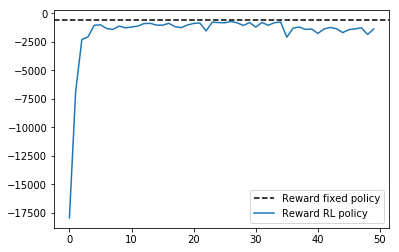

In [97]:
plt.axhline(y=np.mean(reward_hist), color = "black",linestyle = "--")
plt.plot(reward_hist_NN)
plt.legend(["Reward fixed policy","Reward RL policy"])

In [108]:
history_array = np.asarray(history)
history_array.shape

(50, 8)

In [110]:
first_iter = np.asarray(history_array[0,:])

In [114]:
first_iter[]

[-0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -2.0,
 -5.0,
 -7.0,
 -9.0,
 -12.0,
 -14.0,
 -16.0,
 -19.0,
 -20.0,
 -21.0,
 -21.0,
 -22.0,
 -25.0,
 -30.0,
 -33.0,
 -34.0,
 -37.0,
 -38.0,
 -41.0,
 -41.0,
 -42.0,
 -45.0,
 -46.0,
 -41.0,
 -25.0,
 -12.0,
 -4.0,
 -2.0,
 -2.0,
 -3.0,
 -3.0,
 -3.0,
 -2.0,
 -5.0,
 -5.0,
 -1.0,
 -8.0,
 -11.0,
 -14.0,
 -17.0,
 -19.0,
 -22.0,
 -22.0,
 -23.0,
 -23.0,
 -23.0,
 -25.0,
 -26.0,
 -29.0,
 -32.0,
 -33.0,
 -34.0,
 -35.0,
 -38.0,
 -42.0,
 -46.0,
 -49.0,
 -51.0,
 -51.0,
 -53.0,
 -49.0,
 -43.0,
 -44.0,
 -42.0,
 -51.0,
 -55.0,
 -53.0,
 -43.0,
 -27.0,
 -21.0,
 -21.0,
 -27.0,
 -34.0,
 -45.0,
 -57.0,
 -57.0,
 -54.0,
 -53.0,
 -42.0,
 -25.0,
 -15.0,
 -16.0,
 -29.0,
 -38.0,
 -52.0,
 -66.0,
 -64.0,
 -61.0,
 -52.0,
 -44.0,
 -38.0,
 -44.0,
 -46.0,
 -51.0,
 -51.0,
 -43.0,
 -38.0,
 -29.0,
 -28.0,
 -34.0,
 -42.0,
 -36.0,
 -41.0,
 -47.0,
 -45.0,
 -41.0,
 -40.0,
 -42.0,
 -40.0,
 -32.0,
 -24.0,
 -29.0,
 -26.0,
 -32.0,
 -32.0,
 -29.0,
 -35.0,
 -38.0,
 -47.0,
 -58.0,
 -62.0,
 -58.0,
 -64

Text(0.5, 1.0, 'speed of cars link 1 vs 2')

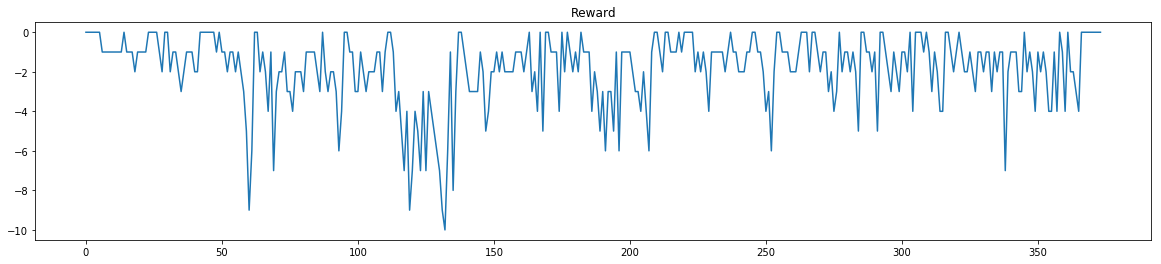

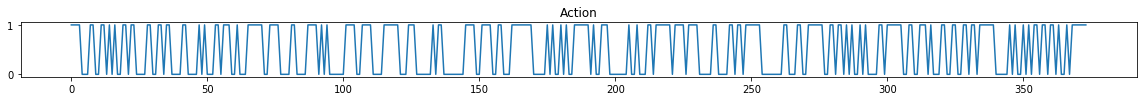

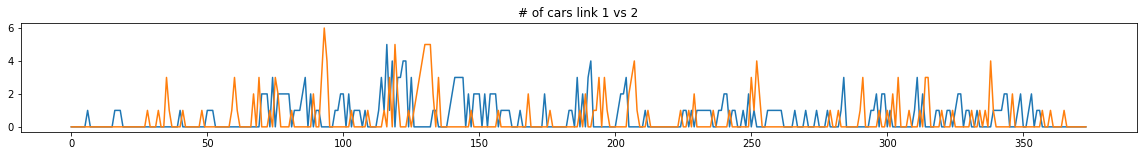

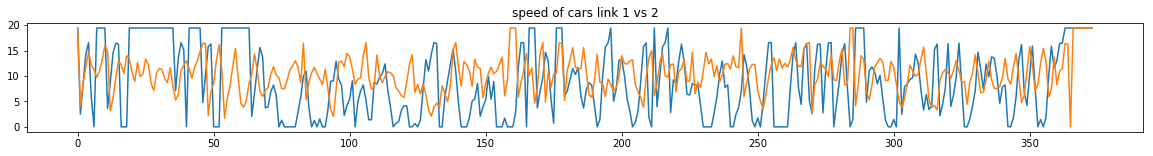

In [100]:
state = np.asarray(state_evol)

x = np.linspace(0,state[:,:,0].T.shape[1]-1,state[:,:,0].T.shape[1])

plt.figure(figsize = (20,4))
plt.plot(reward_evol)
plt.title("Reward")
plt.figure(figsize = (20,1))
plt.plot(action_evol)
plt.title("Action")
plt.figure(figsize = (20,2))
plt.plot(x, state[:,:,0], state[:,:,1])
plt.title("# of cars link 1 vs 2")
plt.figure(figsize = (20,2))
plt.plot(x, state[:,:,4], state[:,:,5])
plt.title("speed of cars link 1 vs 2")

In [90]:
step_evol

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [63]:
state[:,:,0].T.shape[1]

374

In [76]:
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15